In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from torch import nn
from collections import defaultdict
from torch.utils.data import SequentialSampler
from fastai3D import mysampler
import configparser
#from fastai3D import functions
#from fastai3D import loader #does not comply 

# Configure and Filter data

In [3]:
config = configparser.ConfigParser()
config.read('train_3D_oat.ini')

['train_3D_oat.ini']

In [4]:
path = Path(config['data']['dir'])
path.ls()

[PosixPath('/home/suze/seed_images/Data_for_ML_Test/train/Oat_test/NewLabels'),
 PosixPath('/home/suze/seed_images/Data_for_ML_Test/train/Oat_test/Images'),
 PosixPath('/home/suze/seed_images/Data_for_ML_Test/train/Oat_test/Test'),
 PosixPath('/home/suze/seed_images/Data_for_ML_Test/train/Oat_test/models'),
 PosixPath('/home/suze/seed_images/Data_for_ML_Test/train/Oat_test/Oat_big.pkl'),
 PosixPath('/home/suze/seed_images/Data_for_ML_Test/train/Oat_test/Oat_3D_big.pkl'),
 PosixPath('/home/suze/seed_images/Data_for_ML_Test/train/Oat_test/Oat_norot_big.pkl'),
 PosixPath('/home/suze/seed_images/Data_for_ML_Test/train/Oat_test/Oat_no_tfms.pkl'),
 PosixPath('/home/suze/seed_images/Data_for_ML_Test/train/Oat_test/valid.txt')]

In [5]:
#path = Path('/home/suze/Documents/Thesis/seed_images/Data_for_ML_Test/train') #suze_device
#path = Path('/home/suze/seed_images/Data_for_ML_Test//test_model/Barley_test')
#path.ls()

In [6]:
#path_img = path/'Images' #should later be provided through ini file
#path_lbl = path/'Labels' #should later be provided through ini file #suze_device
#path_lbl = path/'NewLabels' #should later be provided through ini file

In [7]:
path_img = path/config['data']['images']
path_lbl = path/config['data']['labels']
valid = config['data']['valid']
classes = int(config['data']['classes'])
model_name = config['data']['model']

Uncomment in case of file issues

In [8]:
#img_names=get_image_files(path_img)
#img_names[:3]
#lbl_names=get_image_files(path_lbl)
#lbl_names[:3]

function to find mask matching the image

In [9]:
#def get_mask(x):
#    return PosixPath(str(x)
#            .replace('train','NewLabels')
#            .replace('valid','NewLabels'))
            #.replace('resampled', 'labels'))

uncomment for error testing

In [10]:
#mask = open_mask(get_mask(img_names[0]))
#mask.show()
#img = open_image(img_names[0])
#img.show()

In [11]:
#src_size = np.array(mask.shape[1:])
#src_size,mask.data

In [12]:
def get_mask(img):
    return (path_lbl)/img.name

def filter_background(img_list):
    include=[]
    for img in img_list:
        mask = open_mask(get_mask(img))
        count_total=(torch.unique(mask.data, return_counts=True))
        if not count_total[0].tolist() == [0]:
            include.append(img)
    return include

"""function to filter out images that only contain background; used to filter in the API; 
function has to return a boolean
slow, every mask has to be opened to check the values"""
def check_back(img):
    mask = open_mask(get_mask(img))
    count_total=(torch.unique(mask.data, return_counts=True))
    if not count_total[0].tolist() == [0]:
        return True
    else:
        return False

def count_mask(img_list):
    img_list = filter_background(img_list)
    count_classes = defaultdict(int)
    for img in img_list:
        #return the occurence of every class in the mask for an image
        mask = open_mask(get_mask(img))
        count_total = torch.unique(mask.data, return_counts=True)
        classes=count_total[0].tolist()
        count_real=count_total[1].tolist()
        for x, y in zip(classes, count_real):
            count_classes[x] += y
    return count_classes

def img_train(path_img, valid):
    #create a list of images not in validation set
    path = path_img.parent
    valid_names = loadtxt_str(path/valid)
    img_names = get_image_files(path_img)
    train_img = list(filter(lambda x: (x.name not in valid_names), img_names))
    return train_img

def acc_seeds(input, target):
    target = target.squeeze(1)
    mask = target != 0 #not interested in background
    return (input.argmax(dim=1)[mask] == target[mask]).float().mean()

### Calculate appropriate weights


In [ ]:
train_img = img_train(path_img, valid)

In [ ]:
#%time classes_count = count_mask(train_img)
#classes_count
#slow for big sets, make faster?
classes_count = defaultdict(int, {0: 2257029582, 1: 1081204683, 2: 118606496, 3: 68549863})

Check to make sure all classes are represented in the training set.

In [ ]:
if len(classes_count.items()) != classes: print('Not all classes present in training data.')

In [ ]:
#append occurences in a list 
#seems redundant
#counts = []
#for c in classes_count:
#    counts.append(classes_count[c])
#counts
counts = [2257029582, 1081204683, 118606496, 68549863]

In [ ]:
weight_ratios =[min(counts)/x for x in counts]
weight_ratios
#weight_ratios = [0.030371716678722734, 0.06340137448331788, 0.5779604432458741, 1.0]

# Data Loading
Load in data and apply transformations etc

In [13]:
#Configure settings for training
bs = int(config['training_settings']['batch_size'])
wd = float(config['training_settings']['wd'])
lr = float(config['training_settings']['lr'])
size_s = int(config['training_settings']['size_s'])
size_m = int(config['training_settings']['size_m'])
size_l = int(config['training_settings']['size_l'])
epochs_s1 = int(config['training_settings']['epochs_s1'])
epochs_s2 = int(config['training_settings']['epochs_s2'])
epochs_m = int(config['training_settings']['epochs_m'])
epochs_l = int(config['training_settings']['epochs_l'])

In [ ]:
src = (SegmentationItemList.from_folder(path)
       .filter_by_folder(include=config['data']['images'])
       .filter_by_func(check_back)
       .split_by_fname_file(valid)
       .label_from_func(get_mask, classes=list(range(classes))))

In [ ]:
#data = (src.transform(get_transforms(), tfm_y=True, size=128)
#       .databunch(bs=1)
#       .normalize())
#TO DO: transforms need to be applied after batching 
#data = (src.transform(tfm_y=True,
#        size=size_s)
#       .databunch(bs=1)
#       .normalize())
#data.show_batch(4, figsize=(10,7))
#data.batch_size

In [ ]:
data = (src.transform(tfm_y=True,
        size=size_s)
       .databunch(bs=1)
       .normalize(imagenet_stats))

### Change to custom sampler for order within batches

In [ ]:
from fastai3D import loader
data.train_dl = data.train_dl.new(shuffle=False, drop_last=False, sampler=None, batch_sampler=mysampler.OrderedBatchSampler(SequentialSampler(data.train_dl), bs, True))

In [ ]:
data

In [ ]:
#data.add_tfm(rotate(degrees=(90,90), p=1))
#data.train_ds.transform(rotate(degrees=(90,90), p=.3))

In [ ]:
data.show_batch(4, figsize=(10,7))

In [ ]:
#data
#print(data.batch_size)

# Create learner

In [14]:
metrics=acc_seeds

In [ ]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [ ]:
#set class weights
class_weights=torch.FloatTensor(weight_ratios)
learn.crit = nn.CrossEntropyLoss(weight=class_weights.cuda())

In [ ]:
#learn.lr_find()
#learn.recorder.plot()

## Add 3D layers to learner

In [19]:
def conv3_layer(ni:int, nf:int, ks:int=3, stride:int=1, padding:int=None, bias:bool=None, is_1d:bool=False,
               is_2d:bool = False, trans_2d:bool = False,
               norm_type:Optional[NormType]=NormType.Batch,  use_activ:bool=True, leaky:float=None,
               transpose:bool=False, init:Callable=nn.init.kaiming_normal_, self_attention:bool=False):
    "Create a sequence of convolutional (`ni` to `nf`), ReLU (if `use_activ`) and batchnorm (if `bn`) layers."
    if padding is None: padding = (ks-1)//2 if not transpose else 0
    bn = norm_type in (NormType.Batch, NormType.BatchZero)
    if bias is None: bias = not bn
    conv_func = nn.ConvTranspose3d if transpose else nn.Conv1d if is_1d else nn.ConvTranspose2d if trans_2d else nn.Conv2d if is_2d else nn.Conv3d
    conv = init_default(conv_func(ni, nf, kernel_size=ks, bias=bias, stride=stride, padding=padding), init)
    if   norm_type==NormType.Weight:   conv = weight_norm(conv)
    elif norm_type==NormType.Spectral: conv = spectral_norm(conv)
    layers = [conv]
    if use_activ: layers.append(relu(True, leaky=leaky))
    if bn: layers.append((nn.BatchNorm1d if is_1d else nn.BatchNorm2d if is_2d else nn.BatchNorm3d)(nf))
    if self_attention: layers.append(SelfAttention(nf))
    return nn.Sequential(*layers)

def stack_1(x):
    return torch.stack(tuple(x), dim = 3)

def stack_2(x):
    return torch.unsqueeze(x,0)

#stack_layers = nn.Sequential(
#    Lambda(lambda x: torch.stack(tuple(x), dim = 3)),
#    Lambda(lambda x: torch.unsqueeze(x,0))
#)

stack_layers = nn.Sequential(
    Lambda(stack_1),
    Lambda(stack_2)
)


def unstack_1(x):
    return torch.squeeze(x, dim = 0)

def unstack_2(x):
    return torch.stack(torch.unbind(x, dim = 3), dim =0)

#unstack_layers = nn.Sequential(
#    Lambda(lambda x: torch.squeeze(x, dim = 0)),
#    Lambda(lambda x: torch.stack(torch.unbind(x, dim = 3), dim =0))
#)

unstack_layers = nn.Sequential(
    Lambda(unstack_1),
    Lambda(unstack_2)
)

just3D = nn.Sequential(conv3_layer(4,64),conv3_layer(64,4))

mini3DUnet = SequentialEx(conv3_layer(4, 64),
                          conv3_layer(64,128),
                          conv3_layer(128,64),
                         conv3_layer(64,4),
                         MergeLayer())

midi3DUnet = SequentialEx(conv3_layer(4,64),
                          SequentialEx(conv3_layer(64,128),
                                       (SequentialEx(conv3_layer(128,128), MergeLayer())),
                                      conv3_layer(128,64), MergeLayer()),
                         conv3_layer(64,4),
                         MergeLayer())

In [ ]:
learn.model.append(stack_layers.cuda())
learn.model.append(midi3DUnet.cuda())
learn.model.append(unstack_layers.cuda())

In [ ]:
learn.summary()

In [ ]:
learn.lr_find()
learn.recorder.plot()

# Start learning

In [ ]:
#learn.fit_one_cycle(cyc_len=1, max_lr=lr)
learn.fit_one_cycle(cyc_len=epochs_s1, max_lr=lr)

In [ ]:
learn.save('stage-small_1')
#learn=None
#gc.collect()

In [ ]:
learn.load('stage-small_1');

In [ ]:
learn.unfreeze()

In [ ]:
lrs = slice(lr/100,lr)

In [ ]:
learn.fit_one_cycle(epochs_s2, lrs)

In [ ]:
learn.save('stage-small_2')

In [ ]:
data_med = (src.transform(tfm_y=True, size=size_m)
       .databunch(bs=1)
       .normalize(imagenet_stats))
data_med.train_dl = data_med.train_dl.new(shuffle=False, drop_last=False, sampler=None, batch_sampler=mysampler.OrderedBatchSampler(SequentialSampler(data_med.train_dl), bs, True))

In [ ]:
learn=None
gc.collect()
learn = unet_learner(data_med, models.resnet34, metrics=metrics, wd=wd)
learn.crit = nn.CrossEntropyLoss(weight=class_weights)
learn.model.append(stack_layers.cuda())
learn.model.append(midi3DUnet.cuda())
learn.model.append(unstack_layers.cuda())

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.load('stage-small_2');

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(epochs_m, lrs)

In [ ]:
learn.save('stage-med')

In [ ]:
data_L = (src.transform(get_transforms(), tfm_y=True, size=size_l)
       .databunch(bs=bs)
       .normalize(imagenet_stats))
data_L.train_dl = data_L.train_dl.new(shuffle=False, drop_last=False, sampler=None, batch_sampler=mysampler.OrderedBatchSampler(SequentialSampler(data_L.train_dl), bs, True))

In [ ]:
learn=None
gc.collect()
learn = unet_learner(data_L, models.resnet34, metrics=metrics, wd=wd)
learn.crit = nn.CrossEntropyLoss(weight=class_weights)
learn.model.append(stack_layers.cuda())
learn.model.append(midi3DUnet.cuda())
learn.model.append(unstack_layers.cuda())

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.load('stage-med');

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(epochs_l, lrs)

In [ ]:
learn.export(model_name)

# Training Interpretations on Validation Set

In [ ]:
from fastai.vision.interpret import *
interp = SegmentationInterpretation.from_learner(learn)

In [ ]:
top_losses, top_idxs = interp.top_losses(sizes=(size_l,size_l))
top_idxs

In [ ]:
learn.validate(data_L.valid_dl)

In [ ]:
mean_cm, single_img_cm = interp._generate_confusion()

In [ ]:
df = interp._plot_intersect_cm(mean_cm, "Mean of Ratio of Intersection given True Label")

In [ ]:
# Look at single worst performing picture
i = top_idxs[0]
df = interp._plot_intersect_cm(single_img_cm[i], f"Ratio of Intersection given True Label, Image:{i}")

In [ ]:
def _interp_show_new(self, ims:ImageSegment, classes:Collection=None, sz:int=20, cmap='tab20',
                    title_suffix:str=None):
        "Show ImageSegment with color mapping labels"
        fig,axes=plt.subplots(1,2,figsize=(sz,sz))
        np_im = to_np(ims.data).copy()
        # tab20 - qualitative colormaps support max of 20 distinc colors
        # if len(classes) > 20 close idxs map to same color
        # image
        if classes is not None:
            class_idxs = [self.c2i[c] for c in classes]
            mask = np.max(np.stack([np_im==i for i in class_idxs]),axis=0)
            np_im = (np_im*mask).astype(np.float)
            np_im[np.where(mask==0)] = np.nan
        im=axes[0].imshow(np_im[0], cmap=cmap)

        # labels
        np_im_labels = list(np.unique(np_im[~np.isnan(np_im)]))
        c = len(np_im_labels); n = math.ceil(np.sqrt(c))
        label_im = np.array(np_im_labels + [np.nan]*(n**2-c)).reshape(n,n)
        axes[1].imshow(label_im, cmap=cmap)
        for i,l in enumerate([self.i2c[l] for l in np_im_labels]):
            div,mod=divmod(i,n)
            #l = "\n".join(wrap(l,10)) if len(l) > 10 else l #bug fix
            axes[1].text(mod, div, f"{l}", ha='center', color='white', fontdict={'size':sz})

        if title_suffix:
            axes[0].set_title(f"{title_suffix}_imsegment")
            axes[1].set_title(f"{title_suffix}_labels")
            
import types
def show_xyz_new(self, i, classes:list=None, sz=10):
        'show (image, true and pred) from self.ds with color mappings, optionally only plot'
        funcType = types.MethodType
        self._interp_show = funcType(_interp_show_new, self)
        x,y = self.ds[i]
        self.ds.show_xys([x],[y], figsize=(sz/2,sz/2))
        self._interp_show(ImageSegment(self.y_true[i]), classes, sz=sz, title_suffix='true')
        self._interp_show(ImageSegment(self.pred_class[i][None,:]), classes, sz=sz, title_suffix='pred')

In [ ]:
funcType = types.MethodType
interp.show_xyz = funcType(show_xyz_new, interp)
interp.show_xyz(i)

# Evalution of Test Data

In [94]:
from PIL import Image
from fastai.vision.interpret import *

In [95]:
#provide config file name through cmd line
config = configparser.ConfigParser()
config.read('pred_3D_oat.ini')

['pred_3D_oat.ini']

In [96]:
path = Path(config['data']['dir_to_model'])
model = (config['data']['model'])
#raw_img = config['data']['raw_images']
#pred_lbl = config['data']['pred_lbl']

In [97]:
learn = load_learner(path, file=model)
#learn.data.single_ds.tfmargs['size'] = None #ensure match to new image size, 

In [98]:
lsiList = (SegmentationItemList.from_folder(path)
       .split_by_folder(train='Images', valid='Test')
       .label_from_func(get_mask, classes=list(range(classes))))

In [99]:
data_test = (lsiList.transform( 
        tfm_y=True, 
        size=300)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [100]:
#from fastai3D import loader
#data_test.train_dl = data_test.train_dl.new(shuffle=False, drop_last=False, sampler=None, batch_sampler=mysampler.OrderedBatchSampler(SequentialSampler(data_test.train_dl), bs, True))

In [101]:
learn.data.valid_dl = data_test.valid_dl

In [102]:
data_test

ImageDataBunch;

Train: LabelList (6347 items)
x: SegmentationItemList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: SegmentationLabelList
ImageSegment (1, 300, 300),ImageSegment (1, 300, 300),ImageSegment (1, 300, 300),ImageSegment (1, 300, 300),ImageSegment (1, 300, 300)
Path: /home/suze/seed_images/Data_for_ML_Test/train/Oat_test;

Valid: LabelList (2316 items)
x: SegmentationItemList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: SegmentationLabelList
ImageSegment (1, 300, 300),ImageSegment (1, 300, 300),ImageSegment (1, 300, 300),ImageSegment (1, 300, 300),ImageSegment (1, 300, 300)
Path: /home/suze/seed_images/Data_for_ML_Test/train/Oat_test;

Test: None

In [103]:
#In [1]: import torch In [2]: torch.cuda.current_device() Out[2]: 0 In [3]: torch.cuda.device(0) 
import torch
torch.cuda.get_device_name()

'GeForce RTX 2080 Ti'

In [104]:
learn.validate(data_test.valid_dl)

[0.04585619, tensor(0.9709)]

In [105]:
# Interpret
interp = SegmentationInterpretation.from_learner(learn)#,ds_type=DatasetType.Valid)
#interp.plot_confusion_matrix()

In [106]:
mean_cm, single_img_cm = interp._generate_confusion()

label,score
0.0,0.997919
1.0,0.968794
2.0,0.953543
3.0,0.561429


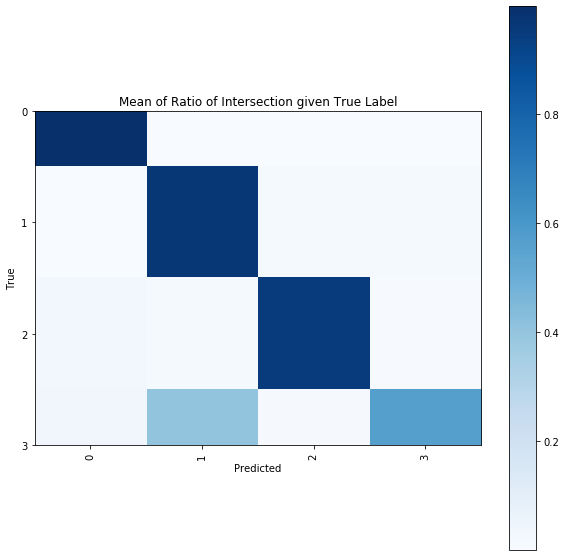

In [107]:
df = interp._plot_intersect_cm(mean_cm, "Mean of Ratio of Intersection given True Label")